In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC, LinearSVC

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

## Exploratory data analysis
in this section we check the datashape, missing values as well as correlations between survivability with other variables

In [2]:
# Check datashape and missing values
train_df
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

,Survived
Sex,
female,0.742038
male,0.188908


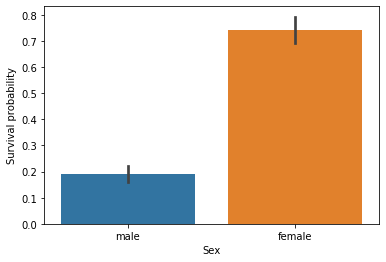

In [3]:
#Check correlation between survival and Sex
g = sns.barplot(x='Sex', y='Survived', data=train_df)
g = g.set_ylabel('Survival probability')

train_df[['Sex','Survived']].groupby('Sex').mean()

#### Survivability vs. Pclass

In [ ]:
g = sns.barplot(x='Pclass', y='Survived', data=train_df, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
# plt.savefig('plots/survival vs. pclass.png')
plt.show()

#### Survivability vs. SibSp

In [ ]:
g = sns.barplot(x='SibSp', y='Survived', data=train_df, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
#plt.savefig('plots/survival vs. sibsp.png', bbox_inches = "tight")
plt.show()

#### Survivability vs. ParCh

In [ ]:
g = sns.barplot(x='Parch', y='Survived', data=train_df, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
plt.show()

#### Survivability vs. Fare

In [ ]:
#Check correlation between survival and Fare
g = sns.violinplot(x = 'Survived', y='Fare', data=train_df)
g = g.set_ylabel('Fare')
plt.show()

## Feature engineering
* Missing values Age: Make a correlation heatmap/factorplot of the variable Age with other variables
* Extract Title from Name. Impute missing values from median age grouped by Sex, Pclass and Title, FamilySize
* Missing values Embarked: Fill with S
* Missing values Cabin: Fill missing with U from Unknown
* Make FamilySize. Single, small, med, large

### Survivability vs. Ticket
By extracting ticket prefixes (returns X if prefix is not available)

In [ ]:
train_df['Ticket'].head() 

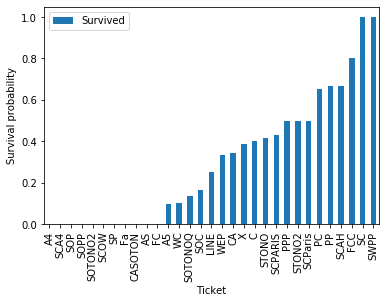

In [4]:
train = train_df.copy()
test = test_df.copy()
data = [train, test]

for dataset in data:
    Ticket = []
    for i in list(dataset.Ticket):
        if not i.isdigit():
            Ticket.append(i.replace(".","").replace("/","").strip().split(" ")[0])
        else:
            Ticket.append("X")
    dataset["Ticket"] = Ticket
    
train.groupby('Ticket').mean()[['Survived']].sort_values(by = ['Survived']).plot(kind = 'bar')
plt.ylabel('Survival probability')
plt.show()
# train_df.loc[train_df['Ticket']=='FC']

Check Ticket vs. Pclass

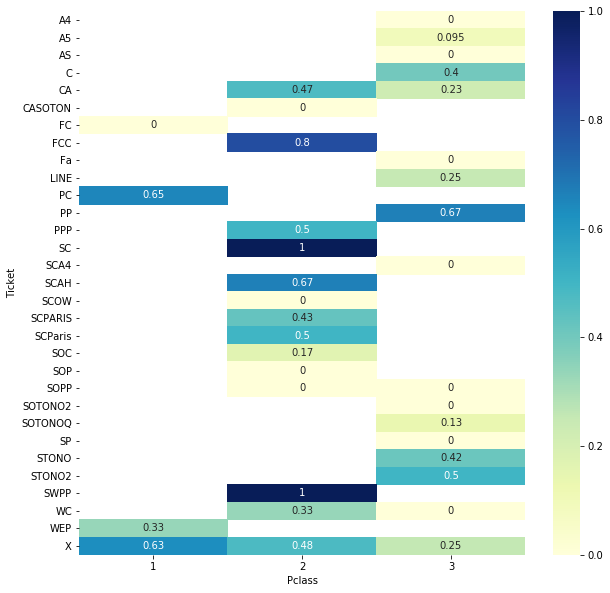

In [5]:
hm_tp = pd.pivot_table(train, values='Survived', index=['Ticket'], columns='Pclass')
plt.figure(figsize=(10,10))
sns.heatmap(hm_tp, annot=True, cmap="YlGnBu")

### Survivability vs. Embarked

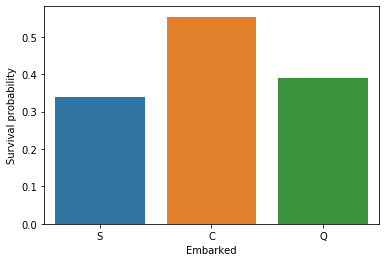

In [6]:
train['Embarked'] = train['Embarked'].fillna('S')  
train['Embarked'].isnull().sum()

g = sns.barplot(x='Embarked', y='Survived', data=train, ci=None)
g = g.set_ylabel('Survival probability')
plt.show()

### Survivability vs. Cabin
By imputing missing values with U from Unknown

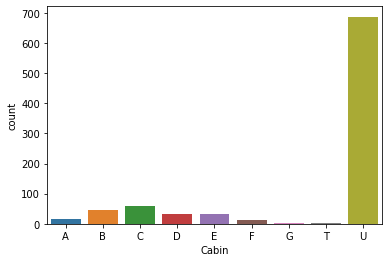

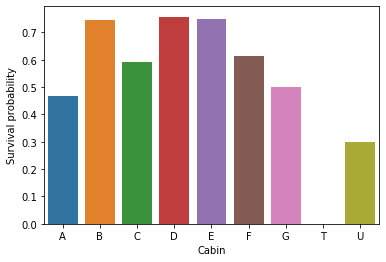

In [7]:
train['Cabin'] = train['Cabin'].fillna('U') 

# Assign each cabin value with its first cabin letter
train['Cabin'] = train['Cabin'].map(lambda c: c[0])  
test['Cabin'] = test['Cabin'].dropna().map(lambda c: c[0])  

g = sns.countplot(train["Cabin"],order=['A','B','C','D','E','F','G','T','U'])
plt.show()

h = sns.barplot(x='Cabin', y='Survived', data=train, order=['A','B','C','D','E','F','G','T','U'], ci=None)
h = h.set_ylabel('Survival probability')
plt.show()

### Fill missing values in Age
By checking first the correlation between the the variable with the other ones

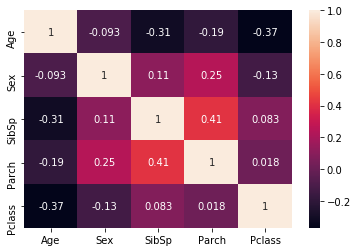

In [8]:
train["Sex"] = train["Sex"].map({"male": 0, "female":1})
g = sns.heatmap(train[["Age","Sex","SibSp","Parch","Pclass"]].corr(),annot=True)
plt.show()

Fill the missing values Age with median age based on high correlated variables: SibSp, Parch and Pclass

/Users/restria.hertomo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/restria.hertomo/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


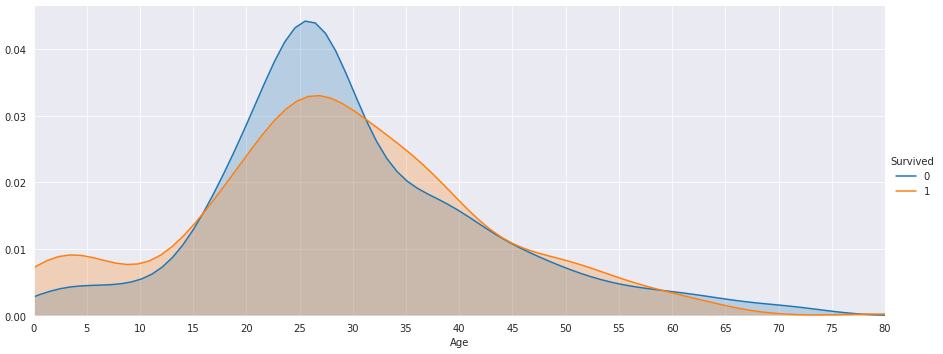

In [9]:
index_missing_age = list(train['Age'][train['Age'].isnull()].index)

for i in index_missing_age:
    median_age = train['Age'].median()
    pred_age = train['Age'][((train['SibSp'] == train.iloc[i]['SibSp']) & (train['Parch'] == train.iloc[i]['Parch']) & (train['Pclass'] == train.iloc[i]['Pclass']))].median()
    if not np.isnan(pred_age):
        train['Age'].iloc[i] = pred_age
    else:
        train['Age'].iloc[i] = median_age     

# df1 = pd.DataFrame(train_df[['Age','SibSp', 'Parch', 'Pclass']])
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Age', shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Age'].max() + 1, 5), xlim=(0, train_df['Age'].max()))

Bin age roughly according to the distribution above and making each bin roughly the same size

In [10]:
for dataset in data:
    # dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 23), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 23) & (dataset['Age'] <= 26), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 44), 'Age'] = 4   
    dataset.loc[(dataset['Age'] > 44), 'Age'] = 5
 
# train['Age'].value_counts().sort_index(ascending=True)
# # age_groups = data["Age"]
# train_df['AgeGroup'] = train['Age']
# test_df['AgeGroup'] = test['Age']

### Make new column "Title" from names

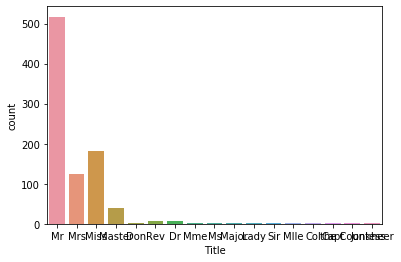

<Figure size 1080x720 with 0 Axes>

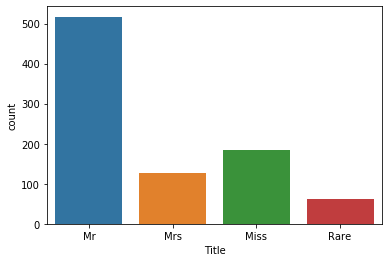

In [11]:
# dataset = pd.concat([train, test], sort=False).drop(columns='Survived')

for dataset in data:    
    titles = [] 
    for i in list(dataset['Name']):
         titles.append(i.split(',')[1].split('.')[0].strip())
    dataset['Title'] = titles     

g = sns.countplot(x='Title', data=train)
# plt.rcParams['figure.figsize']=(15,5)
# plt.tick_params(axis= 'x', labelsize = 8)
plt.figure(figsize=(15,10))
plt.show()

# train_df['Title'].head() 
# train_df['Title'].value_counts() 
# train_df['Title'].nunique() 

# Group Mlle and Ms together with Miss as well as Mme with Mrs and the upper class people together
for dataset in data: 
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'],'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme'],'Mrs')
    
# Cluster other categories with low frequency
for dataset in data: 
    dataset['Title'] = dataset['Title'].replace(['Master', 'Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 
                                               'the Countess', 'Jonkheer'], 'Rare')  
g = sns.countplot(x='Title', data=train)
plt.show()

Put fare into groups

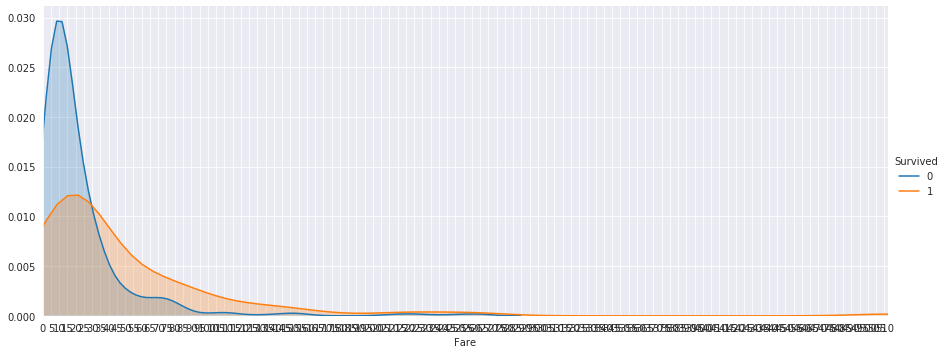

In [12]:
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Fare', shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Fare'].max() + 1, 5), xlim=(0, train['Fare'].max()))

There are 248 unique Fare values. We can bin them.

In [13]:
for dataset in data:
    dataset['qbin_Fare'] = pd.qcut(dataset['Fare'], q=5)
    
train['qbin_Fare'].value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: qbin_Fare, dtype: int64

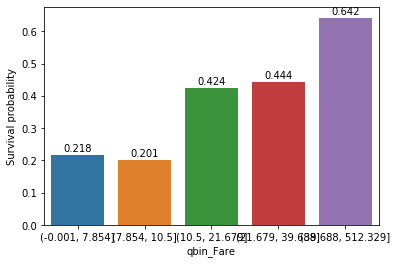

<Figure size 2160x1440 with 0 Axes>

In [14]:
g = sns.barplot(x='qbin_Fare', y='Survived', data=train, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
plt.figure(figsize=(30,20))
plt.show()

In [15]:
train.drop(columns=['Name', 'PassengerId', 'Fare'], inplace=True, axis=1)
test.drop(columns=['Name', 'PassengerId', 'Fare'], inplace=True, axis=1)

## Build classifier

Encode, split, scale

In [16]:
# print(train.dtypes)
cat_col = ['Ticket', 'Cabin', 'Embarked', 'Title', 'qbin_Fare']

cat_col_encoded_train = pd.get_dummies(train, columns=cat_col)
cat_col_encoded_test = pd.get_dummies(test, columns=cat_col)

X_train = cat_col_encoded_train.drop("Survived", axis=1)
Y_train = cat_col_encoded_train["Survived"]
X_test  = cat_col_encoded_test

In [19]:
random_state = 1        # Fixate a random state so that the results are reproducible
n_jobs = -1

logreg = LogisticRegression(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
cart = DecisionTreeClassifier(random_state=random_state)

clf = []        # List of algorithms
clf.append(logreg)
clf.append(rf)
clf.append(cart)


kfold = StratifiedKFold(n_splits=5)
cross_val_results = []      # Returns n-fold results of cross validation of each predictor
for classifier in clf:
    cv_score = cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    cross_val_results.append(cv_score)

cv_means = []    # Returns the means of the n-fold cross val results
cv_std = []      # Returns the standard deviation of the n-fold cross val results
for cv in cross_val_results:
    cv_means.append(cv.mean())
    cv_std.append(cv.std())   

cv_res = pd.DataFrame({"Cross Val Means":cv_means, "Cross Val Errors":cv_std, "Algorithm":["Logistic Regression", "Random Forest", "CART"]})
cross_val_results

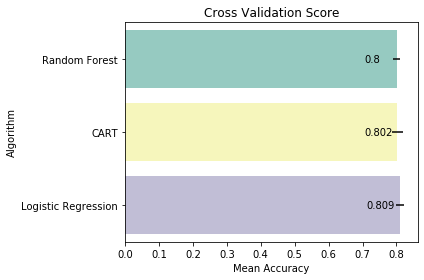

In [21]:
order = cv_res.sort_values('Cross Val Means')      # Order bars in ascending order
g = sns.barplot("Cross Val Means","Algorithm",data = cv_res, order=order['Algorithm'], palette="Set3",orient = "h", **{'xerr':cv_std})

for i in g.patches:         # Put labels on bars
    width = i.get_width()-(i.get_width()*0.12)        # Put labels left of the end of the bar
    g.text(width, i.get_y() + i.get_height()/2, round(i.get_width(),3), color='black', va="center")
    
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Score")
plt.tight_layout()  
plt.show()

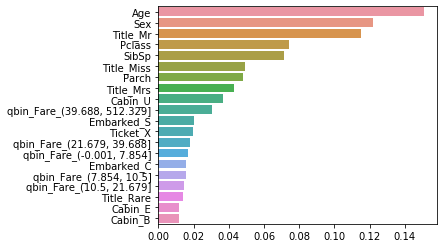

In [66]:
# Make predictions using our best model (Decision Tree)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_train)

nrows = ncols = 0
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(5,4))

indices = np.argsort(rf.feature_importances_)[::-1][:20] 
g = sns.barplot(y=X_train.columns[indices], x = rf.feature_importances_[indices], orient='h')
# plt.figure(figsize=(50,10))
plt.show()

Steps:



Evaluate model
Feature importance check
Train model again only with important features
"""

In [26]:
# cv_means.best_score_

for i in clf:
    output = cross_validate(i, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1, return_estimator =True)

for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)


Features sorted by their score for estimator 0:
                             importance
Title_Mr                       0.347995
Pclass                         0.129512
Age                            0.117789
SibSp                          0.068358
Parch                          0.031361
Cabin_E                        0.025706
Sex                            0.025291
Ticket_X                       0.024869
qbin_Fare_(21.679, 39.688]     0.017949
qbin_Fare_(39.688, 512.329]    0.015880
qbin_Fare_(7.854, 10.5]        0.015653
Embarked_S                     0.014082
qbin_Fare_(10.5, 21.679]       0.013615
Cabin_D                        0.013258
Ticket_PC                      0.012473
Embarked_C                     0.012142
Ticket_SWPP                    0.011139
Cabin_B                        0.010647
qbin_Fare_(-0.001, 7.854]      0.009896
Ticket_STONO                   0.009829
Title_Mrs                      0.008991
Cabin_C                        0.008423
Cabin_A                        0

In [62]:
output

{'fit_time': array([0.00381088, 0.00493813, 0.00381899, 0.0041368 , 0.0039742 ]),
 'score_time': array([0.00108409, 0.00090694, 0.00101209, 0.00116611, 0.00089979]),
 'estimator': (DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=1, splitter='best'),
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
      

In [46]:
cart.fit(X_train, Y_train)
Y_pred_cart = cart.predict(X_train)

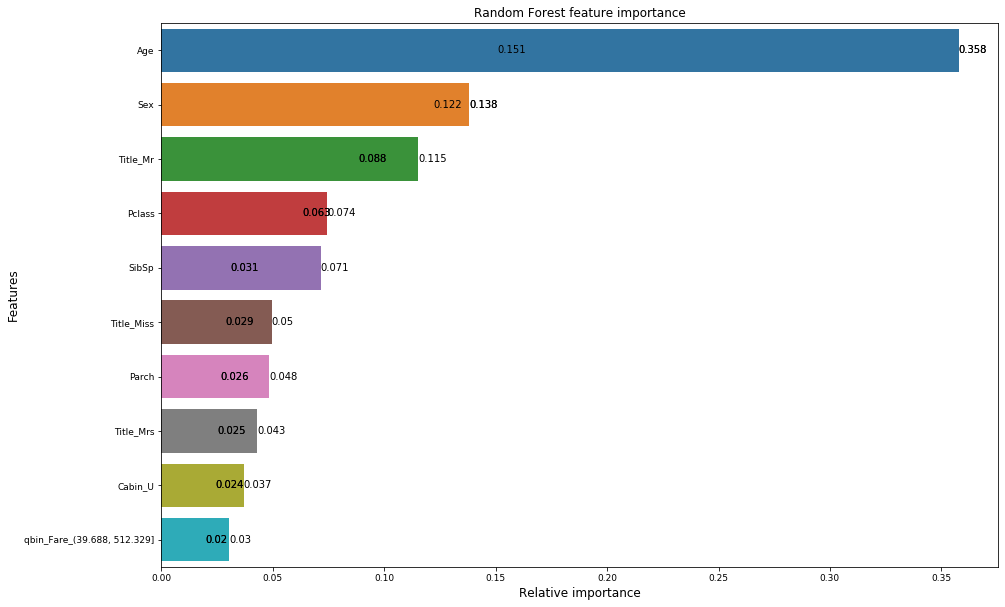

In [49]:
nrows = ncols = 0
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,10))

names_classifiers = [("CART",cart), ("Random Forest",rf)]

nclassifier = 0
for i in names_classifiers:
        name = i[0]
        classifier = i[1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:10] 
        g = sns.barplot(y=X_train.columns[indices], x = classifier.feature_importances_[indices], orient='h')
        for s in g.patches:
            width = s.get_width()       # Put labels left of the end of the bar
            g.text(width, s.get_y() + s.get_height()/2, round(s.get_width(),3), color='black', va="center")
        # nested for loop doesnt work properly. RF has two label on each bar
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")